# Vector Reflectivity Equation Comparison

This notebook compares the forward and adjoint of the vector reflectivity based acoustic wave equation with classical operators.

In [41]:
import numpy as np
from devito import *
from examples.seismic import setup_geometry, RickerSource, Receiver, plot_velocity,\
    SeismicModel

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Finite differences parameters

In [42]:
SPACE_ORDER = 2
TIME_ORDER = 2

## Model

We start by definin the model parameters

In [43]:
NX = 101
NZ = 101

SHAPE = (NX, NZ)
ORIGIN = (0, 0)
SPACING = (5, 5)
SPACE_ORDER = 2
TIME_ORDER = 2
DTYPE = np.float64
NBL = 50

Now, we define a function to generate our wave velocity profile.

In [44]:
def gen_vp(vp_list: list, shape, dtype = np.float64):
    """
    Generates a layer cake model based on a list of P-wave velocities
    """
    vp = np.ones(shape, dtype)
    nlayers = len(vp_list)
    
    for i, vpi in enumerate(vp_list):
        idx_top = i*shape[1]//nlayers
        idx_bottom = (i+1)*shape[1]//nlayers
        vp[:, idx_top : idx_bottom] *= vpi
    
    return vp

We will construct a 5 layer cake model. The layers' P-wave velocities are defined by the `vp_list` variable.

The density profile is estimated with the Gardner's relation:

$$
\rho = 0.31 (v_P \times 10^3)^{0.25}
$$

where $v_P$ is the P-wave velocity in km/s.

In [45]:
vp_list = [1.5, 2.0, 3.5, 4.0, 6.0]
vp = gen_vp(vp_list, SHAPE, DTYPE)

rho = 0.31*(vp[:]*1000.)**0.25
b = 1/rho

model = SeismicModel(
     vp=vp, b=b, origin=ORIGIN, spacing=SPACING, shape=SHAPE, space_order=SPACE_ORDER, 
     nbl=NBL, bcs='damp', dtype=DTYPE, staggered=NODE
)

Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.01 s


Here is what our model looks like.

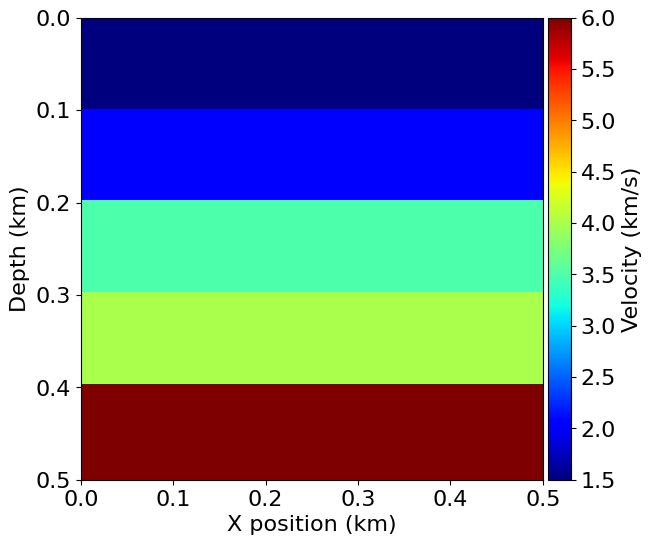

In [46]:
plot_velocity(model)

## Acquisition geometry

We will perform a 700ms acquisition with a 20 Hz peak frequency Ricker source.

In [47]:
tn = 700
f0 = 0.020
dt = model.critical_dt

geometry = setup_geometry(model, tn, f0)
geometry.resample(dt)

<!-- ## Source and receivers creators -->
We will now define two functions to help us create source and receivers.

In [48]:
# Function to create sources and receivers
def src_rec(model, geometry, src_pos, rec_depth, nrec):
    src = RickerSource(name='src', grid=model.grid, f0=geometry.f0, 
                       time_range=geometry.time_axis)

    rec = Receiver(name='rec', grid=model.grid, npoint=nrec,
                   time_range=geometry.time_axis)

    src.coordinates.data[:, 0] = src_pos[0]
    src.coordinates.data[:, 1] = src_pos[1]
    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=nrec)
    rec.coordinates.data[:, 1] = rec_depth
    
    return src, rec


# Function to create adjoint sources
def adjoint_src(model, geometry, src_pos):
    srca = Receiver(name='srca', grid=model.grid,
                    time_range=geometry.time_axis,
                    npoint=1)

    srca.coordinates.data[:, 0] = src_pos[0]
    srca.coordinates.data[:, 1] = src_pos[1]

    return srca

## Operators

We define a class to encapsulate the different forward and adjoint operators

In [49]:
class OpWrapper():
    """
    A class to encapsulate forward and adjoint operators.

    Usage:
        ```
        def forward(model, geometry, src, rec):
            ...
        
        def adjoint(model, geometry, rec, srca=None):
            ...

        op = OpWrapper(forward, adjoint)

        op(model, geometry, src, rec) # Executes forward
        op.T(model, geometry, rec, srca=None) # Executes adjoint
        ```
    """
    def __init__(self, forward, adjoint):
        self.forward = forward
        self.adjoint = adjoint

    def __call__(self, model, geometry, src, rec, **kwargs):
        """
        Executes forward operator
        """
        return self.forward(model, geometry, src, rec, **kwargs)
    
    def T(self, model, geometry, rec, srca=None, **kwargs):
        """
        Executes adjoint operator
        """
        return self.adjoint(model, geometry, rec, srca, **kwargs)

Now we define operators for the vector reflectivity based PDE and the classical PDE. 

### Vector Reflectivity PDE

The wave equation as presented by [Whitmore et al. (2020)](https://doi.org/10.1190/segam2020-3424516.1), but multiplied by $m = \dfrac{1}{v_p^2}$. We rewrite the vector relfectivity as

$$
\begin{aligned}
\mathbf{R} &= \frac{1}{2} \frac{\nabla (v_p \rho)}{v_p \rho}\\
    &= \frac{1}{2}\left( \frac{\nabla v_p}{v_p} + \frac{\nabla \rho}{\rho} \right)\\
    &= \frac{1}{2}\left( \frac{\nabla v_p}{v_p} - \frac{\nabla b}{b} \right)
\end{aligned}
$$

- Forward:

    <!-- $$
        m\frac{\partial^2 u}{\partial t^2} - \left[ \nabla^2u + \frac{1}{v_p}\nabla v_p \cdot \nabla u - 2 \mathbf{R} \cdot \nabla u \right] = S
    $$ -->
    
    $$
        m\frac{\partial^2 u}{\partial t^2} - \nabla^2u + \left(-\frac{1}{v_p}\nabla v_p + 2 \mathbf{R}\right) \cdot \nabla u = S
    $$

    Here, $u$ is the forward wavefield and $S$ is the source term.

- Backward:

    <!-- $$
        m\frac{\partial^2 v}{\partial t^2} - \left[ \nabla^2v + \nabla \cdot \left(\frac{1}{v_p}(\nabla v_p) v\right) - 2  \nabla \cdot \mathbf{R} v \right] = R
    $$ -->
    $$
        m\frac{\partial^2 v}{\partial t^2} - \nabla^2v - \nabla \cdot \left[\left(-\frac{1}{v_p}\nabla v_p + 2 \mathbf{R}\right) v\right] = R
    $$

    Here, $v$ is the adjoint wavefield and $R$ is the receiver term, which will be injected backwards in time.

In [50]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER, staggered=NODE)

    m = model.m
    r = model.r
    vp = model.vp
    dt = model.grid.stepping_dim.spacing

    pde = m * u.dt2 - u.laplace + (- 1/vp*grad(vp) + 2*r).T * grad(u) + model.damp * u.dt

    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model: ModelViscoacoustic, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER, staggered=NODE)
    m = model.m
    vp = model.vp
    r = model.r
    dt = model.grid.stepping_dim.spacing

    pde = m * v.dt2 - v.laplace - div((-grad(vp)/vp + 2*r) * v, .5) + model.damp * v.dt.T
    
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_vector_reflectivity = OpWrapper(forward, adjoint)

### Classical PDE

The classical acoustic wave equation with variable density $\rho$. We write it in terms of $v_P$ and $b = \dfrac{1}{\rho}$

- Forward:

    <!-- $$
        m\frac{\partial^2 u}{\partial t^2} - \rho \nabla \cdot \left(\frac{1}{\rho} \nabla u\right) = S
    $$
    or -->
    $$
        m\frac{\partial^2 u}{\partial t^2} - \frac{1}{b} \nabla \cdot \left(b \nabla u\right) = S
    $$

- Backward:

    $$
        m\frac{\partial^2 v}{\partial t^2} - \nabla \cdot \left[b \nabla \left( \frac{v}{b} \right)\right] = R
    $$


In [51]:
def forward(model, geometry, src, rec):
    u = TimeFunction(name='u', grid=model.grid, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*u.dt2 - rho * div(b * grad(u, .5), -.5) + model.damp * u.dt
    stencil = [Eq(u.forward, solve(pde, u.forward))]

    src_term = src.inject(field=u.forward, expr=src * dt**2/model.m)
    rec_term = rec.interpolate(expr=u)

    op = Operator(stencil + src_term + rec_term, subs=model.spacing_map)
    op(dt=geometry.dt)
    
    return u


def adjoint(model, geometry, rec, srca=None):
    v = TimeFunction(name='v', grid=model.grid, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    rho = 1/model.b
    b = model.b
    m = model.m
    dt = model.grid.stepping_dim.spacing

    pde = m*v.dt2 - div(b * grad(rho * v, .5), -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * dt**2 / m)

    terms = stencil
    terms += rec_term

    if srca:
        srca_term = srca.interpolate(expr=v)
        terms += srca_term

    op = Operator(terms, subs=model.spacing_map)
    op(dt=geometry.dt)
    return v

L_classical = OpWrapper(forward, adjoint)

## Comparison

In this section we will compare the output between the two operators.

### Seismic data computation

In [52]:
src_pos = geometry.src_positions[0]
rec_depth = geometry.rec_positions[0][1]
nrec = geometry.nrec

In [53]:
src_vector_reflectivity, rec_vector_reflectivity = src_rec(
    model, geometry, src_pos, rec_depth, nrec
)
srca_vector_reflectivity = adjoint_src(model, geometry, src_pos)

u_vector_reflectivity = L_vector_reflectivity(
    model, geometry, src_vector_reflectivity, rec_vector_reflectivity
)
v_vector_reflectivity = L_vector_reflectivity.T(
    model, geometry, rec_vector_reflectivity, srca_vector_reflectivity
)

Operator `Kernel` ran in 0.50 s
Operator `Kernel` ran in 0.68 s


In [54]:
src_classical, rec_classical = src_rec(model, geometry, src_pos, rec_depth, nrec)
srca_classical = adjoint_src(model, geometry, src_pos)

u_classical = L_classical(model, geometry, src_classical, rec_classical)
v_classical = L_classical.T(model, geometry, rec_classical, srca_classical)

Operator `Kernel` ran in 0.50 s
Operator `Kernel` ran in 1.22 s


### Plotting data

In [55]:
def plot_data(recs, names, model, t0, tn, colorbar=True, scale_factor=1/10):
    fig, axes = plt.subplots(1, len(recs), figsize=(8*len(recs), 8))

    for i, rec in enumerate(recs):
        ax = (len(recs) > 1) and axes[i] or axes

        scale = np.max(rec) * scale_factor
        extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
                1e-3*tn, t0]

        plot = ax.imshow(rec, vmin=-scale, vmax=scale, cmap=cm.gray, extent=extent)
        ax.set_title(names[i])
        ax.set_xlabel('X position (km)')
        if i == 0:
            ax.set_ylabel('Time (s)')

        # Create aligned colorbar on the right
        if colorbar:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(plot, cax=cax)

    fig.tight_layout()
    fig.show()

/tmp/ipykernel_5088/2912567463.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


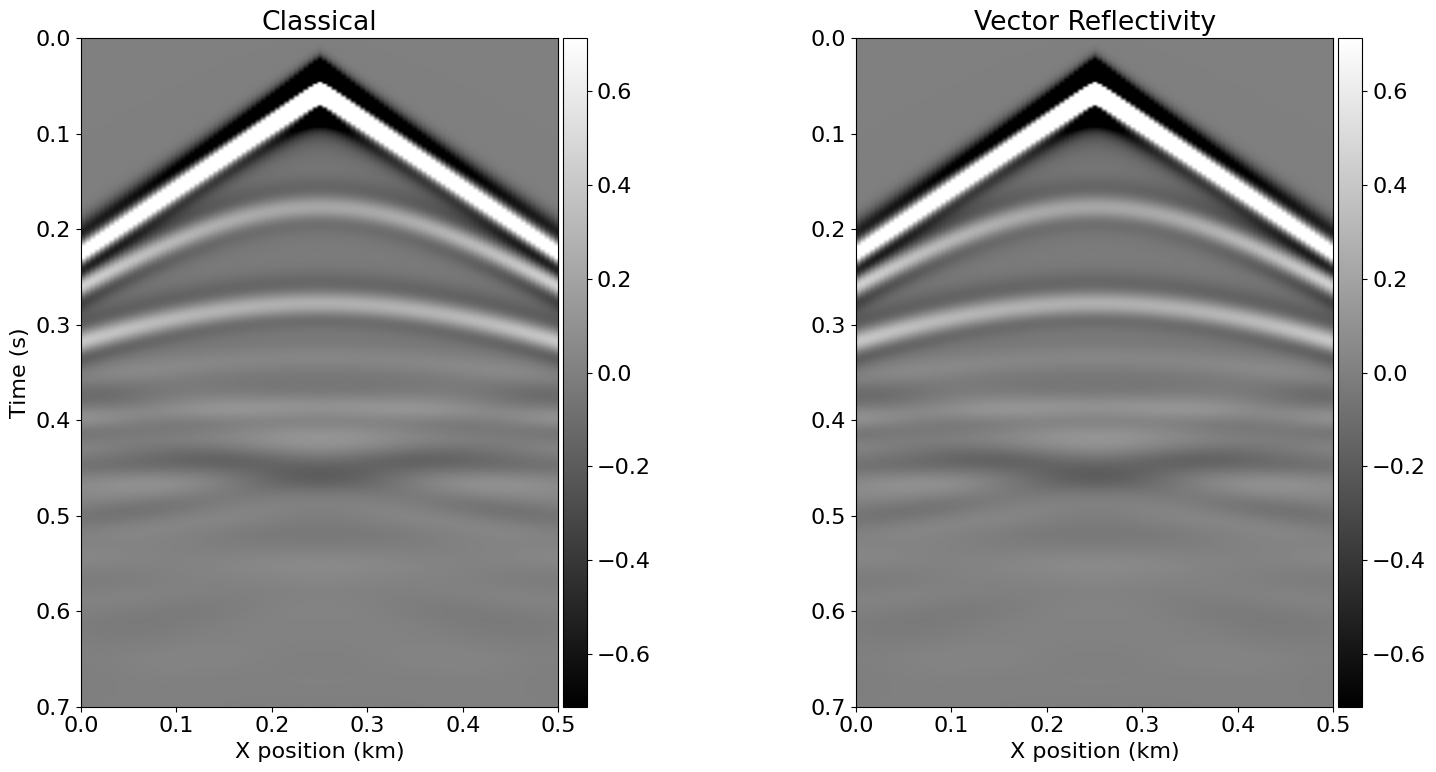

In [56]:
recs = [rec_classical.data, rec_vector_reflectivity.data]
srcas = [srca_classical.data, srca_vector_reflectivity.data]
names = ['Classical', 'Vector Reflectivity']

plot_data(recs, names, model, geometry.t0, geometry.tn)

In [57]:
def plot_trace(recs, labels, tr_idx, geometry, title='', start_idx = 0):
    t_axis = geometry.time_axis.time_values

    for i, rec in enumerate(recs):
        plt.plot(rec[start_idx:, tr_idx], t_axis[start_idx:], label=labels[i], ls='-'*(i+1))

        plt.legend(fontsize='small')
        plt.title(title)
        plt.xlabel('Amplitude')
        plt.ylabel('Time (ms)')

        plt.grid()
    plt.gca().invert_yaxis()

    plt.show()

We compute the root mean squared (RMS) error of the outputs

In [58]:
n = np.size(rec_classical.data)
RMS = (np.sum((rec_classical.data - rec_vector_reflectivity.data)**2)/n)**0.5

In [59]:
n = np.size(srca_classical.data)
RMS_T = (np.sum((srca_classical.data - srca_vector_reflectivity.data)**2)/n)**0.5

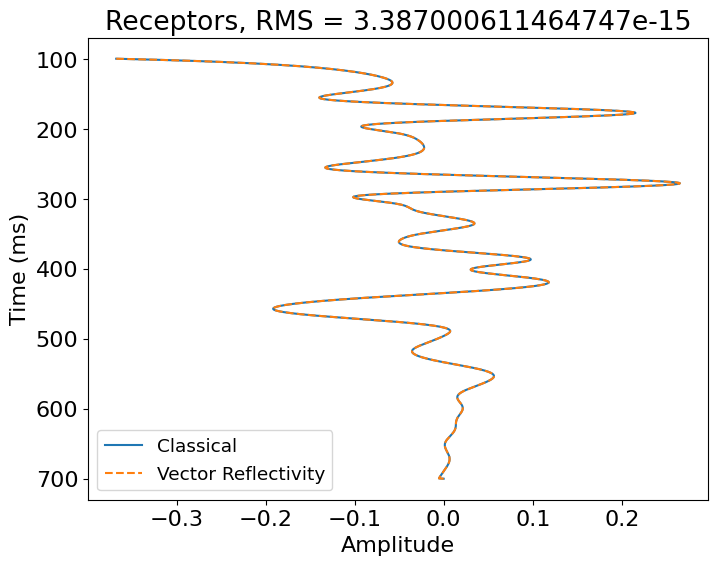

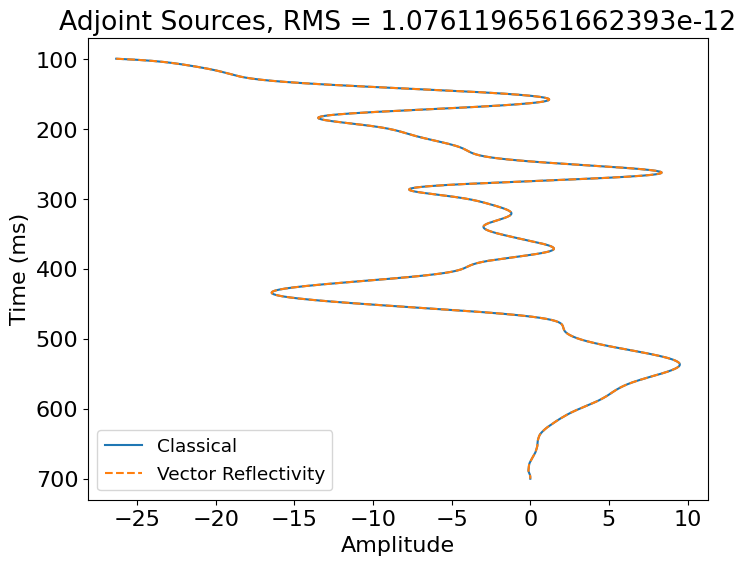

In [60]:
tr_idx = rec_vector_reflectivity.data.shape[1]//2
start_idx = int(100/geometry.dt)

plot_trace(recs, names, tr_idx, geometry, f'Receptors, RMS = {RMS}', start_idx=start_idx)
plot_trace(srcas, names, 0, geometry, f'Adjoint Sources, RMS = {RMS_T}', start_idx=start_idx)

## Adjoint Test

In [61]:
if model.dtype == np.float64:
    eps = 1e-11
elif model.dtype == np.float32:
    eps = 1e-6

In [62]:
term1 = norm(rec_vector_reflectivity) ** 2 # <x, A^*y>
term2 = srca_vector_reflectivity.data.T @ src_vector_reflectivity.data # <Ax, y>

print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
      % (term1, term2, (term1 - term2)/term1, term1/term2))

assert np.isclose((term1 - term2)/term1, 0., atol=eps)

<x, A*y>: 17449.004274, <Ax,y>: 17449.004274, difference: -3.7529e-15, ratio: 1.000000


/tmp/ipykernel_5088/3703702338.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('<x, A*y>: %f, <Ax,y>: %f, difference: %4.4e, ratio: %f'
